# Problem Set 2

1. Add market power considerations to the basic mixed integer program that we discussed in class, following BMS (2008). For now, ignore forward contracts. Given that the model has only technologies (and no firms), pretend that each technology is a firm.

   a) What are the level of markups compared to the competitive equilibrium?

2. Introduce the notion of forward contracts to the model. Given that these are unobserved, you can make different assumptions to calibrate them. It is often easy to interpret them as a percent of their equilibrium quantity, even if then they are not quite "sunk" (e.g., see Puller, 2007; Reguant, 2014). This parameter can also be intepreted as a "conduct" parameter.

   a) Write a function that solves the equilibrium for different values of the conduct parameter and plot markups as a function of those.

3. Introduce competitive investment to the model. Allow investment for three technologies (New Gas, Wind, Solar). The fixed costs are provided in the tech file, which I annualized to be representative of annual costs.

   a) What is the baseline level of investment? We will use the zero profit condition in which the marginal technology just breaks even. You will need to add new variables for the capacity of new gas, wind, and solar, which are now set to zero as a parameter. You will need to expand the use of binary variables to include a new binary variable that equals 1 if investment in a technology is positive.
       -> Hint: As of now, u1 and u2 multiply the capacity of power plants. Use the M formulation to go around this multiplication for the techs with endogenoous investment.
   
   b) Does optimal investment change if you allow technologies to exercise market power as in part 2?

In [1]:
## LIBRARY AND PATH PREP
begin

    using Pkg
    Pkg.add(["DataFrames", "CSV", "JuMP", "HiGHS", "Plots", "Printf", "StatsBase"])

    using DataFrames
    using CSV
    using JuMP
    using HiGHS
    using Plots
    using Printf
    using StatsBase

    dirpath = "/Users/marreguant/Dropbox/TEACHING/GRAD/Econ_498_2023/pset1/"

end

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


"/Users/marreguant/Dropbox/TEACHING/GRAD/Econ_498_2023/pset1/"

## Data

In [2]:
## DATA PREP
begin

    dfclust = CSV.read(string(dirpath,"data_jaere_clustered.csv"), DataFrame);

    # Re-scaling -- note correction for 8.76
    dfclust.weights = 8.76 * dfclust.weights / sum(dfclust.weights);

    # Here only one demand type to make it easier
    dfclust.demand = dfclust.q_residential + dfclust.q_commercial + dfclust.q_industrial;

    # Calibrate demand based on elasticities (using 0.1 here as only one final demand)
    elas = [.1, .2, .5, .3];
    dfclust.b = elas[1] * dfclust.demand ./ dfclust.price;  # slope
    dfclust.a = dfclust.demand + dfclust.b .* dfclust.price;  # intercept

    # Calibrate imports (using elas 0.3)
    dfclust.bm = elas[4] * dfclust.imports ./ dfclust.price;  # slope
    dfclust.am = dfclust.imports - dfclust.bm .* dfclust.price;  # intercept

    dfclust[:, [:demand,:price,:a,:b,:am,:bm]]

    tech = CSV.read(string(dirpath,"data_technology.csv"), DataFrame);
    afactor = (1 - (1 / (1.05^20.0))) / 0.05;
    tech.F = tech.F ./afactor;
    tech.F2 = tech.F2 ./afactor;
    tech

end

Row,techname,heatrate,heatrate2,F,capLB,capUB,new,renewable,solar,thermal,e,e2,c,c2,F2
,String15,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,Hydro/Nuclear,10.0,0.0,0.0,1.0,1.0,0,0,0,0,0.0,0.0,10.0,0.0,0.0
2,Existing 1,6.67199,0.0929123,0.0,11.5,11.5,0,0,0,1,0.360184,0.0048861,23.352,0.325193,0.0
3,Existing 2,9.79412,0.286247,0.0,14.5,14.5,0,0,0,1,0.546134,0.0110777,34.2794,1.00187,0.0
4,Existing 3,13.8181,20.5352,0.0,0.578,0.578,0,0,0,1,0.816768,0.234476,48.3634,71.8731,0.0
5,New Gas,6.6,0.0,78.4773,0.0,0.0,1,0,0,1,0.35,0.0,23.352,0.325193,1.56955
6,Wind,0.0,0.0,100.303,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,2.00606
7,Solar,0.0,0.0,100.303,0.0,0.0,1,1,1,0,0.0,0.0,0.0,0.0,2.00606


## Modifications to code

1. We add a parameter theta that allows for market power. When theta = 0, firms have no forward contracts and market power is maximized.

2. To derive the markup formula, note that I account for the import supply curve, which disciplines firms ability to exercise market power. Note also that I use the competitive baseline to set the markup calculation, as in BBW (2002).

3. Adding investment follows the code that you could see in class, introducing a new binary variable for whether to invest in a technology or not.

In [3]:
## Clear market based on first-order conditions
function clear_market_foc(data::DataFrame, tech::DataFrame; theta=1.0, solve_invest=false, import_slope=true)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            HiGHS.Optimizer)
        );

    set_silent(model)

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods
    M = 1e4;
    
    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, shadow[1:T, 1:I] >= 0);  # price wedge if at capacity
    @variable(model, 0 <= K[5:I] <= 50.0);  # new capacity
    @variable(model, profit[5:I] <= 0.0); # tech annual profits, at most zero in equilibrium
    @variable(model, u1[1:T, 1:I], Bin);  # if tech used
    @variable(model, u2[1:T, 1:I], Bin);  # if tech at max
    @variable(model, u3[5:I], Bin);  # if tech is built

    @objective(model, Min, sum(price[t] * data.weights[t] for t=1:T));

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Capacity constraints
    @constraint(model, [t=1:T], 
        quantity[t,1] <= u1[t,1] * data.hydronuc[t]); #we can only use the technology if u1 = 1
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= u1[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T, i=5:I], 
        quantity[t,i] <= u1[t,i] * M);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= K[5]);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= K[6] * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,7] <= K[7] * data.solar_cap[t]);

    @constraint(model, [t=1:T], 
        quantity[t,1] >= u2[t,1] * data.hydronuc[t]); #if u2 = u1 = 1, hydronuc <= q <= hydronuc
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] >= u2[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] >= K[5] - M * (1.0-u2[t,5]));
    @constraint(model, [t=1:T], 
        quantity[t,6] >= K[6] * data.wind_cap[t] - M * (1.0-u2[t,6]));
    @constraint(model, [t=1:T], 
        quantity[t,7] >= K[7] * data.solar_cap[t] - M * (1.0-u2[t,7]));

    @constraint(model, [t=1:T,i=1:I], u1[t,i] >= u2[t,i]);

    # Constraints on optimality 
    if (import_slope==true)
        @constraint(model, [t=1:T,i=1:I],
            price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - (1.0-theta)/(data.b[t]+data.bm[t])*quantity[t,i] - shadow[t,i] 
            >= -M * (1-u1[t,i]));
        @constraint(model, [t=1:T,i=1:I],
            price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - (1.0-theta)/(data.b[t]+data.bm[t])*quantity[t,i] - shadow[t,i] 
            <= 0.0);
    else
        @constraint(model, [t=1:T,i=1:I],
            price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - (1.0-theta)/data.b[t]*quantity[t,i] - shadow[t,i] 
            >= -M * (1-u1[t,i]));
        @constraint(model, [t=1:T,i=1:I],
            price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - (1.0-theta)/data.b[t]*quantity[t,i] - shadow[t,i] 
            <= 0.0);
    end
    @constraint(model, [t=1:T,i=1:I], shadow[t,i] <= M*u2[t,i]);

    if (solve_invest==true)
        # Definition of profit
        @constraint(model, profit[5] == 
                sum(data.weights[t]*shadow[t,5] for t=1:T) - tech.F[5] - 2 * tech.F2[5]*K[5]);
        @constraint(model, profit[6] == 
                sum(data.weights[t]*shadow[t,6]*data.wind_cap[t] for t=1:T) - tech.F[6] - 2 * tech.F2[6]*K[6]);
        @constraint(model, profit[7] == 
                sum(data.weights[t]*shadow[t,7]*data.solar_cap[t] for t=1:T) - tech.F[7] - 2 * tech.F2[7]*K[7]);

        # Constraints on investment 
        @constraint(model, [i=5:I], profit[i] >= -M*(1.0-u3[i])); # zero profits if investing
        @constraint(model, [i=5:I], K[i] <= M*u3[i]); # capacity only positive if firms can make zero profit
    else
        @constraint(model, [i=5:I], K[i]==0.0)
    end

    # Solve model
    optimize!(model);

   status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="OPTIMAL")
        p = JuMP.value.(price);
        avg_price = mean(p, weights(data.weights));		
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = sum(data.weights[t] * (sum(tech.c[i] * q[t,i] 
                + tech.c2[i] * q[t,i]^2 / 2 for i=1:I) 
                + (imp[t] - data.am[t])^2/(2 * data.bm[t])) for t=1:T)/sum(data.weights);
        shadow = JuMP.value.(shadow);
        u1 = JuMP.value.(u1);
        u2 = JuMP.value.(u2);
        u3 = JuMP.value.(u3);
        K = JuMP.value.(K)[5:I];
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "shadow" => shadow,
            "u1" => u1,
            "u2" => u2,
            "u3" => u3,
            "gas_gw" => K[5],
            "wind_gw" => K[6],
            "solar_gw" => K[7]);
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_foc (generic function with 1 method)

## Part 1
Markups are around 46% with full market power.

In [4]:
# baseline no market power or investment
baseline = clear_market_foc(dfclust, tech)

# with full market power
mkt_power = clear_market_foc(dfclust, tech, theta=0.0)

mean((mkt_power["price"] .- baseline["price"])./mkt_power["price"], weights(dfclust.weights))

0.46143894317633

In [14]:
mkt_power_no_import = clear_market_foc(dfclust, tech, import_slope=false, theta=0.5)

Dict{String, Any} with 14 entries:
  "avg_price" => 66.6682
  "price"     => [83.4497, 65.49, 55.727, 72.6965, 70.5126, 58.7991, 61.5147, 1…
  "gas_gw"    => 0.0
  "status"    => "OPTIMAL"
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [9.46003 8.12782 … 0.0 0.0; 4.0713 6.41014 … 0.0 0.0; … ; 2.61…
  "solar_gw"  => 0.0
  "imports"   => [10.9642, 10.2571, 10.2405, 8.91142, 7.821, 9.56318, 10.4816, …
  "demand"    => [35.0889, 25.2625, 25.3286, 26.7913, 20.1827, 23.3117, 23.7869…
  "shadow"    => [6.57786 0.0 … 83.4497 83.4497; 30.0507 0.0 … 65.49 65.49; … ;…
  "u2"        => [1.0 0.0 … 1.0 1.0; 1.0 0.0 … 1.0 1.0; … ; 1.0 0.0 … 1.0 1.0; …
  "u3"        => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "cost"      => 493.898
  "wind_gw"   => 0.0

## Part 2
Markups are declining with forward contracts.

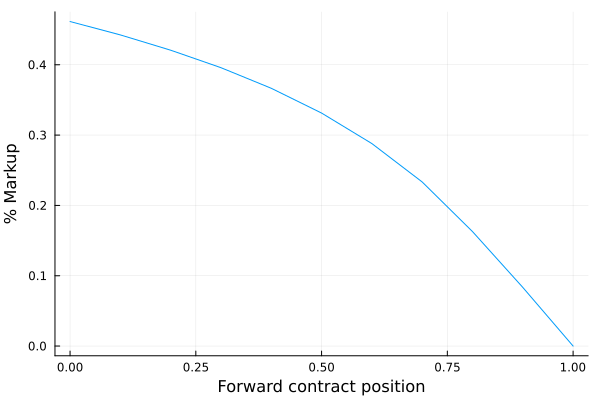

In [6]:
thetaMat = collect(0.0:0.1:1.0)
df_noinvest = DataFrame(theta=Float64[],mkup=Float64[])
for th in thetaMat
    res = clear_market_foc(dfclust, tech, theta=th)
    mkup = mean((res["price"] .- baseline["price"])./res["price"], weights(dfclust.weights))
    push!(df_noinvest, [th, mkup])
end

plot(df_noinvest.theta, df_noinvest.mkup, xlabel="Forward contract position", ylabel="% Markup", legend=false)


## Part 3

Investment disciplines market power but it also distorts it.

Market power makes free entry of renewables more attractive.

In [7]:
baseline = clear_market_foc(dfclust, tech, solve_invest=true)
thetaMat = collect(0.0:0.1:1.0)
df_invest = DataFrame(theta=Float64[],mkup=Float64[],gas_gw=Float64[],wind_gw=Float64[],solar_gw=Float64[])
for th in thetaMat
    res = clear_market_foc(dfclust, tech, theta=th, solve_invest=true)
    mkup = mean((res["price"] .- baseline["price"])./res["price"], weights(dfclust.weights))
    push!(df_invest, [th, mkup, res["gas_gw"], res["wind_gw"], res["solar_gw"]])
end

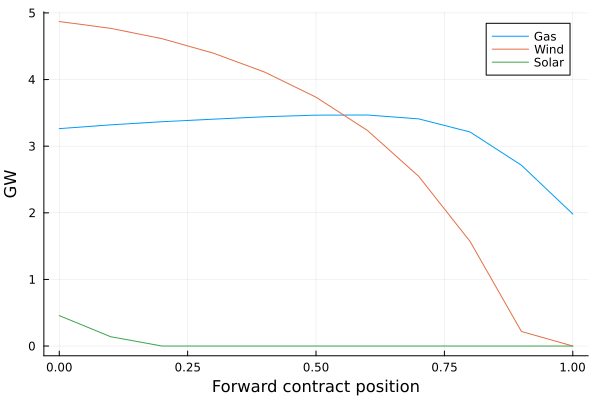

In [8]:
plot(df_invest.theta,df_invest.gas_gw, xlabel="Forward contract position", ylabel="GW", label="Gas")
plot!(df_invest.theta,df_invest.wind_gw, label="Wind")
plot!(df_invest.theta,df_invest.solar_gw, label="Solar")

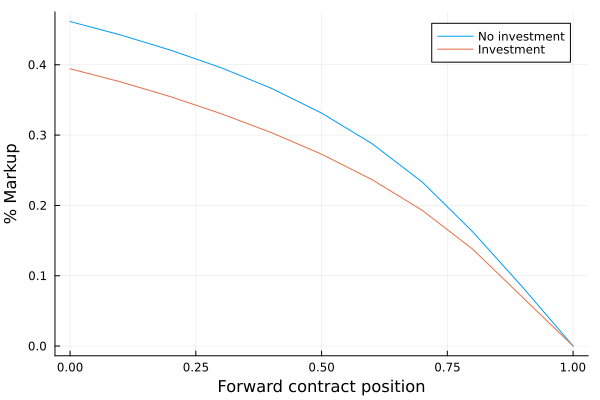

In [9]:
plot(df_noinvest.theta, df_noinvest.mkup, xlabel="Forward contract position", ylabel="% Markup", label="No investment")
plot!(df_invest.theta, df_invest.mkup, label="Investment")

In [10]:
# Check without import slope
mkt_power = clear_market_foc(dfclust, tech, solve_invest=true, import_slope=false, theta=0.0)

Dict{String, Any} with 14 entries:
  "avg_price" => 70.1757
  "price"     => [99.8415, 68.6815, 63.3209, 76.5591, 68.6982, 60.4261, 59.4982…
  "gas_gw"    => 2.84764
  "status"    => "OPTIMAL"
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [6.35472 5.28865 … 1.57304 1.1219; 4.0713 3.53526 … 1.27152 0.…
  "solar_gw"  => 1.7239
  "imports"   => [11.835, 10.4808, 10.8335, 9.1362, 7.7309, 9.69145, 10.328, 9.…
  "demand"    => [33.9294, 25.0071, 24.687, 26.4537, 20.2906, 23.1509, 23.9485,…
  "shadow"    => [0.0 0.0 … 77.6023 83.9803; 7.8028 0.0 … 52.7914 68.5411; … ; …
  "u2"        => [0.0 0.0 … 1.0 1.0; 1.0 0.0 … 1.0 1.0; … ; 1.0 0.0 … 1.0 1.0; …
  "u3"        => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "cost"      => 435.585
  "wind_gw"   => 4.95305